# Sentiment Analysis on Drug Review Dataset (Drugs.com)

In [ ]:
import pandas as pd
import numpy as np
import os
import nltk
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

In [ ]:
'''from google.colab import drive
drive.mount('/content/drive/', force_remount=True)'''

In [6]:
train = pd.read_table("/content/drive/MyDrive/drugsCom_raw/drugsComTrain_raw.tsv")
test = pd.read_table("/content/drive/MyDrive/drugsCom_raw/drugsComTest_raw.tsv")

In [7]:
print(train.shape)
print(test.shape)

(161297, 7)
(53766, 7)


In [8]:
# Merging Train Test Data
df = pd.concat([train , test])
df.shape

(215063, 7)

In [9]:
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [10]:
# Checking for null values
print(df.isnull().sum())

Unnamed: 0        0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64


In [11]:
# Dropping null values since it makes only around 0.55% of whole data
DF = df.dropna()
print(DF.isnull().sum())

Unnamed: 0     0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64


In [12]:
DF.shape

(213869, 7)

In [13]:
Data = DF.drop(columns=['Unnamed: 0'])
Data.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [14]:
# Count of top 10 drugs with rating 1
Data.loc[DF["rating"] == 1] ["drugName"].value_counts().head(10)

Miconazole                            767
Ethinyl estradiol / norethindrone     728
Etonogestrel                          707
Levonorgestrel                        511
Nexplanon                             504
Ethinyl estradiol / norgestimate      464
Medroxyprogesterone                   443
Depo-Provera                          417
Tioconazole                           410
Ethinyl estradiol / levonorgestrel    385
Name: drugName, dtype: int64

In [15]:
# Count of top 10 drugs with rating 10
Data.loc[DF["rating"] == 10] ["drugName"].value_counts().head(10)

Levonorgestrel                       1883
Phentermine                          1079
Etonogestrel                          864
Varenicline                           662
Ethinyl estradiol / norethindrone     601
Escitalopram                          596
Clonazepam                            586
Alprazolam                            565
Sertraline                            550
Plan B                                527
Name: drugName, dtype: int64

In [16]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213869 entries, 0 to 53765
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   drugName     213869 non-null  object 
 1   condition    213869 non-null  object 
 2   review       213869 non-null  object 
 3   rating       213869 non-null  float64
 4   date         213869 non-null  object 
 5   usefulCount  213869 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 11.4+ MB


In [17]:
# Changing Datatype of date from object to datetime64
Data['date'] = pd.to_datetime(Data['date'])
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213869 entries, 0 to 53765
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   drugName     213869 non-null  object        
 1   condition    213869 non-null  object        
 2   review       213869 non-null  object        
 3   rating       213869 non-null  float64       
 4   date         213869 non-null  datetime64[ns]
 5   usefulCount  213869 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 11.4+ MB


In [18]:
# Preprocessing
Data.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,2012-05-20,27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,2010-04-27,192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,2009-12-14,17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,2015-11-03,10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,2016-11-27,37


## Exploratory Data Analysis

### Distribution of Rating

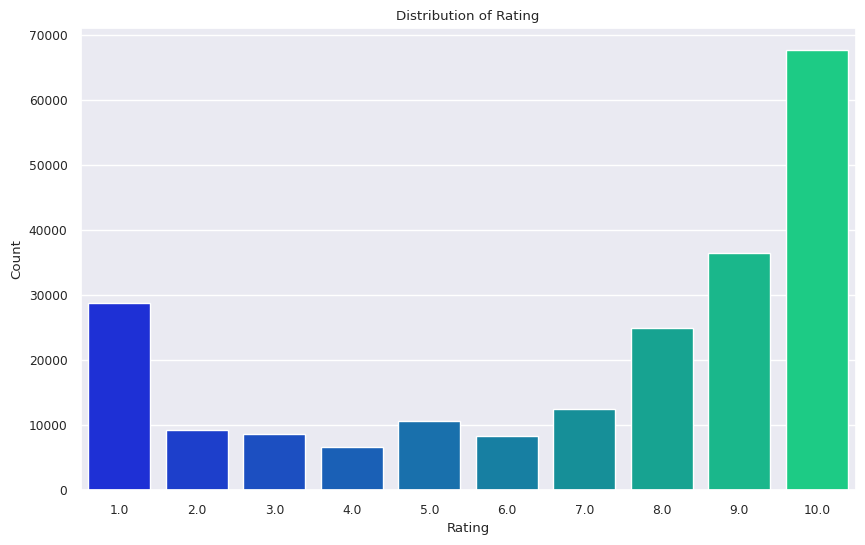

In [19]:
# This barplot show the Distribution of Rating
rate = dict(Data['rating'].value_counts().sort_index())
Rate = list(rate.keys())[0:10]
values = list(rate.values())[0:10]
sns.set(style = 'darkgrid', font_scale = 0.8)
plt.rcParams['figure.figsize'] = [10, 6]

sns_ = sns.barplot(x = Rate, y = values, palette = ('winter'))
sns_.set_title("Distribution of Rating")
sns_.set_xlabel("Rating")
sns_.set_ylabel("Count");

### Top 20 drugs with rating 10

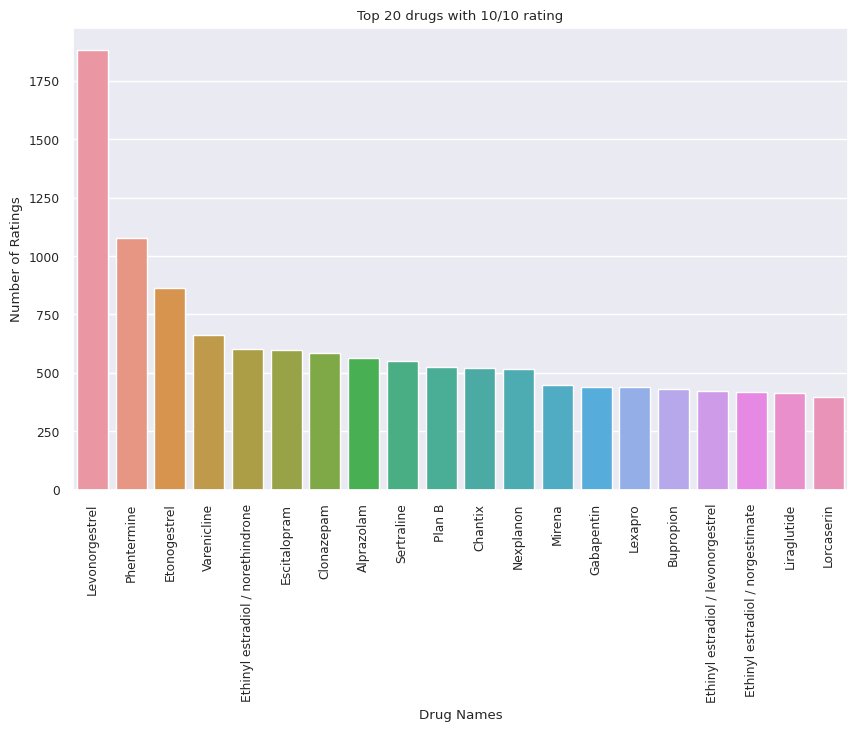

In [20]:
sns.set(font_scale = 0.8, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 6]

rating = dict(Data.loc[Data.rating == 10, "drugName"].value_counts())
drugName = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugName[0:20], y = drug_rating[0:20])

sns_rating.set_title('Top 20 drugs with 10/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

### Top 20 Drugs with 1/10 rating

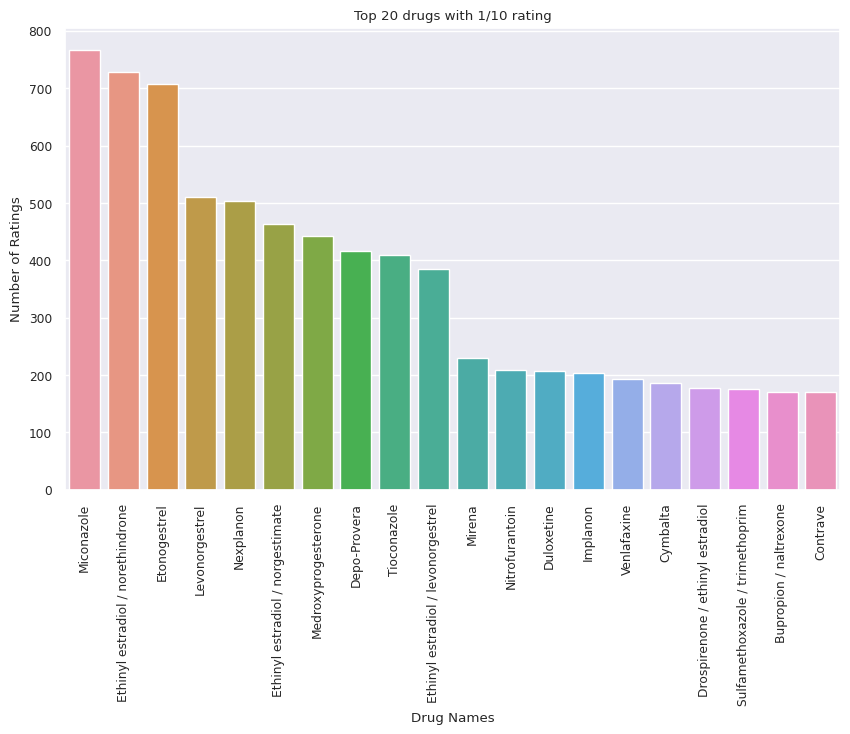

In [21]:
sns.set(font_scale = 0.8, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 6]

rating = dict(Data.loc[Data.rating == 1, "drugName"].value_counts())
drugName = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugName[0:20], y = drug_rating[0:20])

sns_rating.set_title('Top 20 drugs with 1/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

In [22]:
drugName = DF["drugName"].value_counts()
import plotly.express as px
fig = px.bar(drugName[:20], y='drugName',title='Number of Reviews for Top 20 Drugs')
fig.show()

In [23]:
conditions = DF["condition"].value_counts()
import plotly.express as px
fig = px.bar(conditions[:30], y='condition',title='Number of Reviews for Top 30 conditions')
fig.show()

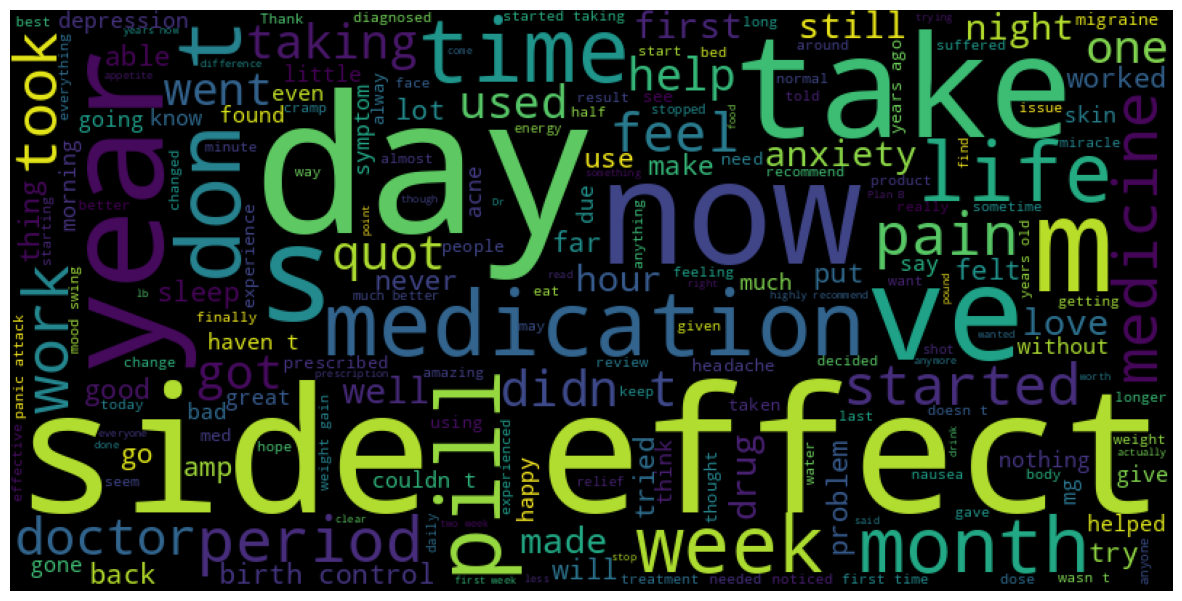

In [24]:
# Word cloud of the reviews with rating equal to 10
df_rate_ten = DF.loc[DF.rating == 10, 'review']
k = (' '.join(df_rate_ten))

wordcloud = WordCloud(width = 800, height = 400).generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off');

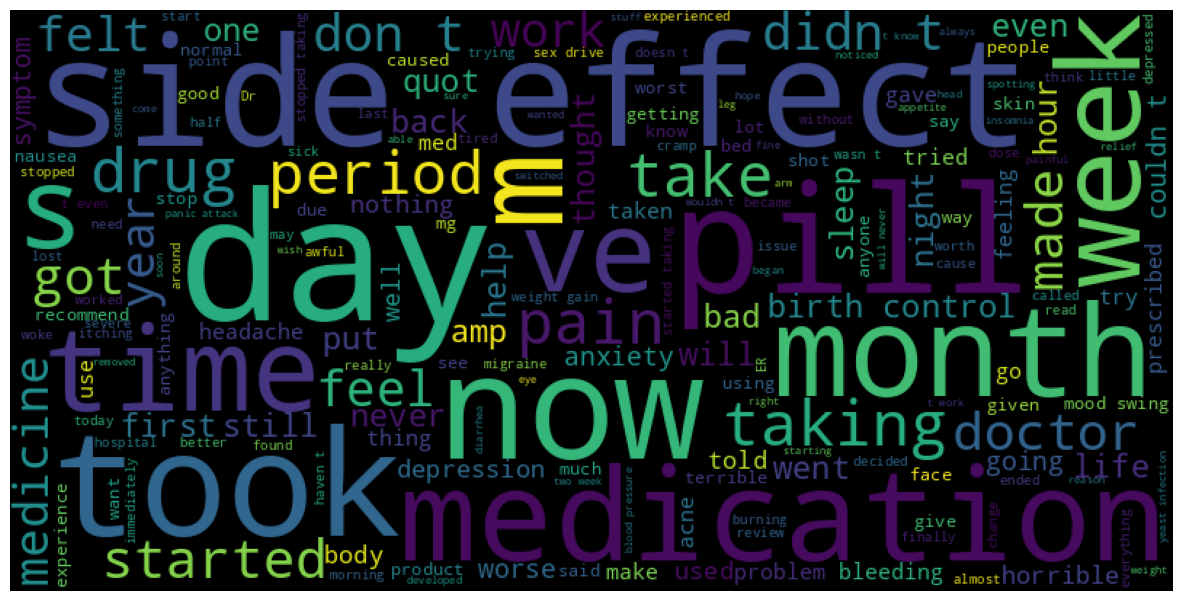

In [25]:
# Word cloud of the reviews with rating equal to 1
df_rate_one = DF.loc[DF.rating == 1, 'review']
k1 = (' '.join(df_rate_one))

wordcloud = WordCloud(width = 800, height = 400).generate(k1)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off');

In [26]:
# text preprocessing
def clean_text(text):
  #convert in lower case
  text=text.lower()
  #next step,apply word_tokenize on given text
  tokens=nltk.word_tokenize(text)
  #keeps alphabets only and remove special charecters and digits 
  #inbuilt function isalpha() means only accept alphabets 
  word_tokens=[w for w in tokens if w.isalpha()]
  #to remove stopwords  
  stop=stopwords.words('english')
  clean_tokens=[w for w in word_tokens if w not in stop]
  #lemmetization of clean_tokens list
  lemma=WordNetLemmatizer()
  lemma_tokens=[lemma.lemmatize(w) for w in clean_tokens]
  #return lemma_tokens
  return ' '.join(lemma_tokens)

In [27]:
print(Data['review'])

0        "It has no side effect, I take it in combinati...
1        "My son is halfway through his fourth week of ...
2        "I used to take another oral contraceptive, wh...
3        "This is my first time using any form of birth...
4        "Suboxone has completely turned my life around...
                               ...                        
53761    "I have taken Tamoxifen for 5 years. Side effe...
53762    "I&#039;ve been taking Lexapro (escitaploprgra...
53763    "I&#039;m married, 34 years old and I have no ...
53764    "I was prescribed Nucynta for severe neck/shou...
53765                                        "It works!!!"
Name: review, Length: 213869, dtype: object


In [28]:
#call function clean_text
#Apply python inbuilt function
Data['review']=Data['review'].apply(clean_text)
Data.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,side effect take combination bystolic mg fish oil,9.0,2012-05-20,27
1,Guanfacine,ADHD,son halfway fourth week intuniv became concern...,8.0,2010-04-27,192
2,Lybrel,Birth Control,used take another oral contraceptive pill cycl...,5.0,2009-12-14,17
3,Ortho Evra,Birth Control,first time using form birth control glad went ...,8.0,2015-11-03,10
4,Buprenorphine / naloxone,Opiate Dependence,suboxone completely turned life around feel he...,9.0,2016-11-27,37


In [29]:
print(Data['review'])

0        side effect take combination bystolic mg fish oil
1        son halfway fourth week intuniv became concern...
2        used take another oral contraceptive pill cycl...
3        first time using form birth control glad went ...
4        suboxone completely turned life around feel he...
                               ...                        
53761    taken tamoxifen year side effect severe sweati...
53762    taking lexapro escitaploprgram since february ...
53763    married year old kid taking pill hassle decide...
53764    prescribed nucynta severe pain taking pill rus...
53765                                                 work
Name: review, Length: 213869, dtype: object


In [30]:
#Sentiment
Data['Sentiment'] = np.where(Data['rating'] > 5, 1, 0)
Data.head()

,drugName,condition,review,rating,date,usefulCount,Sentiment
0,Valsartan,Left Ventricular Dysfunction,side effect take combination bystolic mg fish oil,9.0,2012-05-20,27,1
1,Guanfacine,ADHD,son halfway fourth week intuniv became concern...,8.0,2010-04-27,192,1
2,Lybrel,Birth Control,used take another oral contraceptive pill cycl...,5.0,2009-12-14,17,0
3,Ortho Evra,Birth Control,first time using form birth control glad went ...,8.0,2015-11-03,10,1
4,Buprenorphine / naloxone,Opiate Dependence,suboxone completely turned life around feel he...,9.0,2016-11-27,37,1


In [31]:
Data['Sentiment'].value_counts()

1    149963
0     63906
Name: Sentiment, dtype: int64

<Axes: xlabel='Sentiment', ylabel='count'>

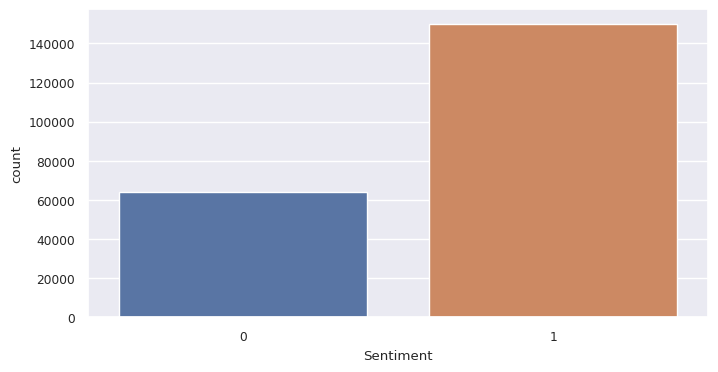

In [32]:
sns.set(font_scale = 0.8, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [8, 4]
sns.countplot(x=Data["Sentiment"])

In [33]:
Data['Sentiment'].describe()

count    213869.000000
mean          0.701191
std           0.457737
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: Sentiment, dtype: float64

### TRAIN TEST SPLIT 

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Data['review'], Data['Sentiment'], test_size=0.2, random_state=0)
print ("The Train set size ", X_train.shape)
print ("The Test set size ", X_test.shape)

The Train set size  (171095,)
The Test set size  (42774,)


## TfidfVectorizer with Logistic Regression


In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [46]:
vect = TfidfVectorizer().fit(X_train)
len(vect.get_feature_names_out())

41867

In [48]:
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)

In [51]:
print("Number of features : %d \n" %len(tfidf.get_feature_names_out()))
print("Show some feature names : \n", tfidf.get_feature_names_out()[::1000])

Number of features : 15961 

Show some feature names : 
 ['aa' 'attacking' 'car' 'convulsion' 'disoder' 'exfoliate' 'glowing'
 'improving' 'lid' 'movie' 'panick' 'proudly' 'risperidal' 'solar' 'tbsp'
 'upcoming']


In [52]:
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

LogisticRegression()

In [63]:
feature_names = np.array(tfidf.get_feature_names_out())
sorted_coef_index = lr.coef_[0].argsort()
print("\nTop 10 features with smallest coefficients", feature_names[sorted_coef_index[:10]])
print("\nTop 10 features with largest coefficients", feature_names[sorted_coef_index[:-11:-1]])


Top 10 features with smallest coefficients ['disappointed' 'worse' 'worst' 'ruined' 'removed' 'useless' 'waste'
 'gained' 'garbage' 'horrible']

Top 10 features with largest coefficients ['love' 'saved' 'miracle' 'amazing' 'best' 'saver' 'great' 'wonderful'
 'grateful' 'complaint']


In [64]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [65]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score

In [66]:
predictions = lr.predict(tfidf.transform(X_test))
modelEvaluation(predictions)


Accuracy on validation set: 0.8371

AUC score : 0.7816

Classification report : 
               precision    recall  f1-score   support

           0       0.77      0.64      0.70     12778
           1       0.86      0.92      0.89     29996

    accuracy                           0.84     42774
   macro avg       0.82      0.78      0.80     42774
weighted avg       0.83      0.84      0.83     42774


Confusion Matrix : 
 [[ 8225  4553]
 [ 2417 27579]]
